In [116]:
from molecular_mpns.config import data_dir
from molecular_mpns.proto_molecule import Molecule
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ExponentialLR
import seaborn as sns

In [117]:
# define simulation params
beta = 15.0
dt = 5e-3
tau = 1
h = tau*dt

# load data
xyz_traj = np.load(str(data_dir)+'/proto_mol_traj.npy')
m,p,d = xyz_traj.shape

xyz_centers = xyz_traj[:,2,:] # pick 'middle' atoms as reference positions
xyz_centers = np.tile(xyz_centers,(1,p))
xyz_traj = xyz_traj.reshape((m,p*d))

In [118]:
# define model

class ProtoFFNet(torch.nn.Module):
    
    def __init__(self,in_dim,h_dim):
        
        super(ProtoFFNet,self).__init__()
        
        self.lin1 = torch.nn.Linear(in_dim,h_dim)
        self.bn1 = torch.nn.BatchNorm1d(h_dim)
        self.lin2 = torch.nn.Linear(h_dim,h_dim)
        self.bn2 = torch.nn.BatchNorm1d(h_dim)
        self.lin3 = torch.nn.Linear(h_dim,h_dim)
        self.bn3 = torch.nn.BatchNorm1d(h_dim)
        self.lin4 = torch.nn.Linear(h_dim,h_dim)
        self.lin5 = torch.nn.Linear(h_dim,1)
        
    def forward(self,x):
        h = self.lin1(x)
        h = torch.nn.functional.silu(h)
        h = self.bn1(h)
        h = self.lin2(h)
        h = torch.nn.functional.silu(h)
        h = self.bn2(h)
        h = self.lin3(h)
        h = torch.nn.functional.silu(h)
        h = self.bn3(h)
        h = self.lin4(h)
        h = torch.nn.functional.silu(h)
        h = self.lin5(h)
        
        return h

In [119]:
# build model
in_dim,h_dim = p*d,128
mod = ProtoFFNet(in_dim,h_dim)
mod = mod.double()

criterion = torch.nn.MSELoss()
opt = torch.optim.Adam(mod.parameters(),lr=1e-3)
sched = ExponentialLR(opt, gamma = 0.95)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mod = mod.to(device)

# train model
split_idx = 1000000
epochs,batch_size = 20,32

for ep in range(epochs):
    batch = 0
    ep_loss = 0.0
    while batch*batch_size < split_idx:
        idx1,idx2 = batch*batch_size,(batch+1)*batch_size
        
        xyz_current = torch.tensor(xyz_traj[idx1:idx2]).to(device)
        xyz_relative = torch.tensor(xyz_traj[idx1:idx2]-xyz_centers[idx1:idx2],requires_grad = True).to(device)
        xyz_next = torch.tensor(xyz_traj[(idx1+tau):(idx2+tau)]).to(device)
        
        xyz_relative
        V = mod(xyz_relative).sum()
        b = -torch.autograd.grad(V,xyz_relative,create_graph = True)[0]
        
        mu = xyz_current+b*h
        loss = (1/(2*beta*h))*criterion(xyz_next,mu)
        
        ep_loss += loss.item()
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        batch += 1
    
    sched.step()
    print('Epoch ' + str(ep+1) + ' Loss: ' + str(ep_loss))

Epoch 1 Loss: 123.07424846076069
Epoch 2 Loss: 118.63286569519262
Epoch 3 Loss: 117.45571794245737
Epoch 4 Loss: 116.86263496481824
Epoch 5 Loss: 116.47380105962137
Epoch 6 Loss: 116.18997607285074
Epoch 7 Loss: 115.9649259497318
Epoch 8 Loss: 115.77736207339619
Epoch 9 Loss: 115.61533434687416
Epoch 10 Loss: 115.47177398088338
Epoch 11 Loss: 115.34233668763868
Epoch 12 Loss: 115.2244095254154
Epoch 13 Loss: 115.11660964890639
Epoch 14 Loss: 115.01656416126094
Epoch 15 Loss: 114.92387543006919
Epoch 16 Loss: 114.83701605816302
Epoch 17 Loss: 114.75573168395665
Epoch 18 Loss: 114.679116858622
Epoch 19 Loss: 114.60702466918457
Epoch 20 Loss: 114.53902988328676


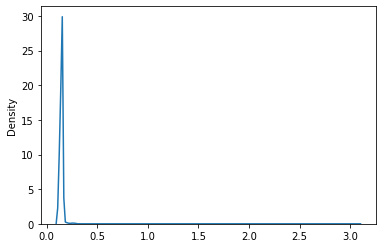

In [120]:
# set up molecular environment 
N = 5
beta = 15.0
kb = 1.0
rb = 2.0
ka = 1.0
ra = np.pi/2
kd = np.array([[0.02, 3], [0.02, 2]])
mol = Molecule(N, beta, kb, rb, ka, ra, kd)

# simulate trajectory
mod = mod.eval()
L = 100000
sim_traj = np.zeros(L)
xyz = xyz_traj[0].reshape((1,p*d))

for i in range(L):
    xyz_center = xyz[0][6:9]
    xyz_center = np.tile(xyz_center,p)
    xyz_tens = torch.tensor(xyz-xyz_center,requires_grad=True).view(1,d*p).to(device)
    V = mod(xyz_tens)
    b = -torch.autograd.grad(V,xyz_tens)[0]
    b = b.detach().cpu().numpy()
    xyz += b*h + np.sqrt((2*h)/beta)*np.random.randn(1,d*p)
    
    xyz_tmp = xyz.reshape((p,d))
    ic = mol._internal_coordinates(xyz_tmp)
    sim_traj[i] = ic[8]

sns.kdeplot(sim_traj)
plt.show()
plt.close()